### Classify t4 by Highest Point

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
dataset = pd.read_csv('Datasets/dataset_mobility.csv')

grouped_df = dataset.groupby(['state', 'mobility_type']).agg({
    'x_time': list,
    'x_date': list,
    'y_ridership_change': list,
    'phase': list,
}).reset_index()

dataset = grouped_df
dataset['t0'] = None

#dataset = dataset[dataset['state'] != 'US']


def update_t0_values(dataset, mobility_type):
    t0_data = pd.read_csv(
        f'Datasets/data/Ts_each_state/2020_{mobility_type}.csv')
    t0_dict = dict(zip(t0_data['state'], t0_data['t0_index']))

    # Map the 'state' in dataset to 't0' using t0_dict
    # If the state is not found in t0_dict, default to 0
    dataset['t0'] = dataset['state'].map(lambda x: t0_dict.get(x, 0))


# Update dataset with t0 values
mobility_types = dataset['mobility_type'].unique()
for mt in mobility_types:
    subset = dataset[dataset['mobility_type'] == mt]
    update_t0_values(subset, mt)
    dataset.loc[subset.index] = subset


def is_derivative_within_bounds(index, derivative):
    """Check if the derivative at the given index and its nearby points are within bounds."""
    lower_bound = max(0, index - 1)
    upper_bound = min(len(derivative), index + 1)
    for i in range(lower_bound, upper_bound):
        if i < len(derivative) and (derivative[i] < -1 or derivative[i] > 1):
            return False
    return True


def find_final_t4_after_t2(original_data, smoothed_data, t0):
    """Find t4 after the minimum point (t2) in the smoothed_data."""
    t2 = np.argmin(original_data)

    derivative = np.diff(smoothed_data)
    zero_crossings = np.where(np.diff(np.sign(derivative)))[0]
    zero_crossings_after_t2 = [zc for zc in zero_crossings if zc > t2]

    if len(zero_crossings_after_t2) == 0:
        return t0, t2, len(smoothed_data) - 1  # Return the last index

    valid_t4_points = [
        zc for zc in zero_crossings_after_t2 if is_derivative_within_bounds(zc, derivative)]
    if valid_t4_points:
        t4_index = valid_t4_points[np.argmax(
            [smoothed_data[i] for i in valid_t4_points])]
        return t0, t2, t4_index + 1

    # Return the last index if no valid t4 found
    return t0, t2, len(smoothed_data) - 1


def process_trajectory_final_t4_after_t2(row, ma_window=7):
    y_changes = list(row['y_ridership_change'])
    smoothed_y_changes = pd.Series(y_changes).rolling(window=ma_window, center=True).mean(
    ).fillna(method='bfill').fillna(method='ffill').tolist()
    t0, t2, t4 = find_final_t4_after_t2(
        y_changes, smoothed_y_changes, row['t0'])
    return t0, t2, t4


# Update dataset with t0, t2, and final t4 values based on the conditions
dataset[['t0', 't2', 't4']] = dataset.apply(
    process_trajectory_final_t4_after_t2, axis=1, result_type='expand')

# Plotting functions


def plot_final_t4_after_t2(row):
    y_changes = list(row['y_ridership_change'])
    smoothed_y_changes = pd.Series(y_changes).rolling(window=7, center=True).mean(
    ).fillna(method='bfill').fillna(method='ffill').tolist()
    derivative = np.diff(smoothed_y_changes)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    ax1.plot(range(len(smoothed_y_changes)), smoothed_y_changes,
             label="Smoothed Ridership Change", alpha=0.7)
    if row['t4']:
        ax1.axvline(row['t4'], color='red',
                    linestyle='--', alpha=0.5, label="t4")
    ax1.axvline(row['t0'], color='blue', linestyle='--', alpha=0.5, label="t0")
    ax1.axvline(row['t2'], color='green',
                linestyle='--', alpha=0.5, label="t2")
    ax1.set_title(
        f"Final t4 after t2 for {row['mobility_type']} in {row['state']}")
    ax1.set_ylabel("Ridership Change")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(range(1, len(smoothed_y_changes)), derivative,
             label="Derivative of Smoothed Ridership Change", color='blue')
    if row['t4']:
        ax2.axvline(row['t4'], color='red',
                    linestyle='--', alpha=0.5, label="t4")
    ax2.axvline(row['t0'], color='blue', linestyle='--', alpha=0.5, label="t0")
    ax2.axvline(row['t2'], color='green',
                linestyle='--', alpha=0.5, label="t2")
    ax2.set_xlabel("Index")
    ax2.set_ylabel("Rate of Change")
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()


# Plotting final t4 after t2 for a few trajectories for demonstration
'''sample_rows = dataset
for _, row in sample_rows.iterrows():
    if row['mobility_type'] == 'grocery_and_pharmacy_percent_change_from_baseline':
        plot_final_t4_after_t2(row)'''

dataset1 = dataset

dataset1


C:\Users\Eddie\AppData\Local\Temp\ipykernel_14732\173443039.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['t0'] = dataset['state'].map(lambda x: t0_dict.get(x, 0))


,state,mobility_type,x_time,x_date,y_ridership_change,phase,t0,t2,t4
0,Alabama,grocery_and_pharmacy_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.454906205, -...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",28,63,87
1,Alabama,parks_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.227272727, 5....","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",21,58,142
2,Alabama,residential_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.187229437, 1....","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",21,17,57
3,Alabama,retail_and_recreation_percent_change_from_base...,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.392135642, 1....","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",17,57,126
4,Alabama,transit_stations_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.971500722, 2....","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",22,57,110
...,...,...,...,...,...,...,...,...,...
307,Wyoming,parks_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.761904762, 6....","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",21,62,110
308,Wyoming,residential_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.80952381, 0.7...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",21,25,62
309,Wyoming,retail_and_recreation_percent_change_from_base...,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.619047619, 3....","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",12,62,127
310,Wyoming,transit_stations_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.142857143, 5....","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",14,61,134


### Highest pt by city/county

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
dataset = pd.read_csv('Datasets/dataset_mobility_1.csv')

grouped_df = dataset.groupby(['city', 'mobility_type']).agg({
    'x_time': list,
    'x_date': list,
    'y_ridership_change': list,
}).reset_index()

dataset = grouped_df
dataset['t0'] = None

#dataset = dataset[dataset['state'] != 'US']


# Update dataset with t0 values
mobility_types = dataset['mobility_type'].unique()
for mt in mobility_types:
    subset = dataset[dataset['mobility_type'] == mt]

    dataset.loc[subset.index] = subset


def is_derivative_within_bounds(index, derivative):
    """Check if the derivative at the given index and its nearby points are within bounds."""
    lower_bound = max(0, index - 1)
    upper_bound = min(len(derivative), index + 1)
    for i in range(lower_bound, upper_bound):
        if i < len(derivative) and (derivative[i] < -1 or derivative[i] > 1):
            return False
    return True


def find_final_t4_after_t2(original_data, smoothed_data):
    """Find t4 after the minimum point (t2) in the smoothed_data."""

    t0 = 0
    t2_smoothed = np.argmin(smoothed_data)
    range_size = 2  # Set the size of the range
    lower_bound = max(0, t2_smoothed - range_size)
    upper_bound = min(len(original_data), t2_smoothed + range_size + 1)

    # Find the exact minimum value within this range in the original data
    t2 = np.argmin(original_data[lower_bound:upper_bound]) + lower_bound

    derivative = np.diff(smoothed_data)
    zero_crossings = np.where(np.diff(np.sign(derivative)))[0]
    zero_crossings_after_t2 = [zc for zc in zero_crossings if zc > t2]

    if len(zero_crossings_after_t2) == 0:
        return t0, t2, len(smoothed_data) - 1  # Return the last index

    valid_t4_points = [
        zc for zc in zero_crossings_after_t2 if is_derivative_within_bounds(zc, derivative)]
    if valid_t4_points:
        t4_index = valid_t4_points[np.argmax(
            [smoothed_data[i] for i in valid_t4_points])]
        return t0, t2, t4_index + 1

    # Return the last index if no valid t4 found
    return t0, t2, len(smoothed_data) - 1


def process_trajectory_final_t4_after_t2(row, ma_window=7):
    y_changes = list(row['y_ridership_change'])
    smoothed_y_changes = pd.Series(y_changes).rolling(window=ma_window, center=True).mean(
    ).fillna(method='bfill').fillna(method='ffill').tolist()
    t0, t2, t4 = find_final_t4_after_t2(
        y_changes, smoothed_y_changes)
    return t0, t2, t4


# Update dataset with t0, t2, and final t4 values based on the conditions
dataset[['t0', 't2', 't4']] = dataset.apply(
    process_trajectory_final_t4_after_t2, axis=1, result_type='expand')

# Plotting functions


def plot_final_t4_after_t2(row):
    y_changes = list(row['y_ridership_change'])
    smoothed_y_changes = pd.Series(y_changes).rolling(window=7, center=True).mean(
    ).fillna(method='bfill').fillna(method='ffill').tolist()
    derivative = np.diff(smoothed_y_changes)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    ax1.plot(range(len(y_changes)), y_changes,
             label="Smoothed Ridership Change", alpha=0.7)
    ax1.plot(range(len(smoothed_y_changes)), smoothed_y_changes,
             label="Smoothed Ridership Change", alpha=0.7)
    if row['t4']:
        ax1.axvline(row['t4'], color='red',
                    linestyle='--', alpha=0.5, label="t4")
    ax1.axvline(row['t0'], color='blue', linestyle='--', alpha=0.5, label="t0")
    ax1.axvline(row['t2'], color='green',
                linestyle='--', alpha=0.5, label="t2")
    ax1.set_title(
        f"Final t4 after t2 for {row['mobility_type']} in {row['city']}")
    ax1.set_ylabel("Ridership Change")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(range(1, len(smoothed_y_changes)), derivative,
             label="Derivative of Smoothed Ridership Change", color='blue')
    if row['t4']:
        ax2.axvline(row['t4'], color='red',
                    linestyle='--', alpha=0.5, label="t4")
    ax2.axvline(row['t0'], color='blue', linestyle='--', alpha=0.5, label="t0")
    ax2.axvline(row['t2'], color='green',
                linestyle='--', alpha=0.5, label="t2")
    ax2.set_xlabel("Index")
    ax2.set_ylabel("Rate of Change")
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()


# Plotting final t4 after t2 for a few trajectories for demonstration
'''sample_rows = dataset
for _, row in sample_rows.iterrows():
    plot_final_t4_after_t2(row)'''

dataset1 = dataset

dataset1


,city,mobility_type,x_time,x_date,y_ridership_change,t0,t2,t4
0,Austin County,grocery_and_pharmacy_percent_change_from_baseline,"[338573, 338574, 338575, 338576, 338577, 33857...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[3.0, 5.0, -5.0, 3.0, 0.0, -9.0, -3.0, 3.0, 0....",0,49,295
1,Austin County,parks_percent_change_from_baseline,"[338573, 338574, 338575, 338576, 338577, 33857...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2
2,Austin County,residential_percent_change_from_baseline,"[338573, 338574, 338575, 338576, 338577, 33857...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[nan, nan, 2.0, 0.0, 1.0, 1.0, -1.0, nan, nan,...",0,0,2
3,Austin County,retail_and_recreation_percent_change_from_base...,"[338573, 338574, 338575, 338576, 338577, 33857...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[3.0, 6.0, 8.0, 3.0, 1.0, -4.0, 4.0, 3.0, 11.0...",0,49,119
4,Austin County,transit_stations_percent_change_from_baseline,"[338573, 338574, 338575, 338576, 338577, 33857...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2
5,Austin County,workplaces_percent_change_from_baseline,"[338573, 338574, 338575, 338576, 338577, 33857...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[-5.0, 3.0, -15.0, 3.0, 1.0, 1.0, 4.0, 5.0, -1...",0,289,291
6,Dallas County,grocery_and_pharmacy_percent_change_from_baseline,"[349892, 349893, 349894, 349895, 349896, 34989...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[1.0, 2.0, 0.0, -4.0, -2.0, 2.0, -2.0, -1.0, -...",0,43,109
7,Dallas County,parks_percent_change_from_baseline,"[349892, 349893, 349894, 349895, 349896, 34989...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[16.0, 50.0, 39.0, -7.0, -8.0, 0.0, 2.0, 18.0,...",0,304,320
8,Dallas County,residential_percent_change_from_baseline,"[349892, 349893, 349894, 349895, 349896, 34989...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[-1.0, -2.0, 4.0, 1.0, 0.0, 0.0, -2.0, -1.0, 1...",0,13,48
9,Dallas County,retail_and_recreation_percent_change_from_base...,"[349892, 349893, 349894, 349895, 349896, 34989...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[4.0, 9.0, 7.0, -4.0, -2.0, 2.0, 3.0, 2.0, 3.0...",0,42,119


KeyError: 'Delta'

### Classify t4 based on Roy's Code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the main dataset
dataset = pd.read_csv('Datasets/dataset_mobility.csv')

grouped_df = dataset.groupby(['state', 'mobility_type']).agg({
    'x_time': list,
    'x_date': list,
    'y_ridership_change': list,
    'phase': list,
}).reset_index()

dataset = grouped_df
dataset = dataset[dataset['state'] != 'US']


def is_derivative_within_bounds(index, derivative):
    """Check if the derivative at the given index and its nearby points are within bounds."""
    lower_bound = max(0, index - 3)
    upper_bound = min(len(derivative), index + 3)
    for i in range(lower_bound, upper_bound):
        if i < len(derivative) and (derivative[i] < -0.25 or derivative[i] > 0.25):
            return False
    return True


def closest(list, Number):
    """Find closest value in a list to given number."""
    if not list:  # Handle empty list
        return None
    aux = [abs(Number-value) for value in list]
    return list[aux.index(min(aux))]


def find_final_t4_from_dataset(smoothed_data, state, mobility_type, t4_dict):
    """Find t4 closest to the one specified in the dataset."""
    t2 = np.argmin(smoothed_data)
    derivative = np.diff(smoothed_data)
    zero_crossings = np.where(np.diff(np.sign(derivative)))[0]
    zero_crossings_after_t2 = [zc for zc in zero_crossings if zc > t2]

    if len(zero_crossings_after_t2) == 0:
        return None

    valid_t4_points = [
        zc for zc in zero_crossings_after_t2 if is_derivative_within_bounds(zc, derivative)]

    target_t4 = t4_dict.get((state, mobility_type), None)
    if not target_t4:
        return None

    t4_index = closest(valid_t4_points, target_t4)
    return t4_index


def process_trajectory_final_t4_from_dataset(row, t4_dict, t0_dict, ma_window=7):
    y_changes = list(row['y_ridership_change'])
    smoothed_y_changes = pd.Series(y_changes).rolling(window=ma_window, center=True).mean(
    ).fillna(method='bfill').fillna(method='ffill').tolist()

    t2 = np.argmin(smoothed_y_changes)
    # Fetch t0 from the t0_dict
    t0 = t0_dict.get((row['state'], row['mobility_type']), None)
    t4 = find_final_t4_from_dataset(
        smoothed_y_changes, row['state'], row['mobility_type'], t4_dict)

    return t0, t2, t4


def plot_final_t4_after_t2(row, t4_dict):
    y_changes = list(row['y_ridership_change'])
    smoothed_y_changes = pd.Series(y_changes).rolling(window=7, center=True).mean(
    ).fillna(method='bfill').fillna(method='ffill').tolist()
    derivative = np.diff(smoothed_y_changes)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

    ax1.plot(range(len(smoothed_y_changes)), smoothed_y_changes,
             label="Smoothed Ridership Change", alpha=0.7)
    if row['t4']:
        ax1.axvline(row['t4'], color='red', linestyle='--',
                    alpha=0.5, label="final_t4_from_dataset")
    if (row['state'], row['mobility_type']) in t4_dict:
        ax1.axvline(t4_dict[(row['state'], row['mobility_type'])],
                    color='green', linestyle='-.', alpha=0.5, label="t4 from dataset")
    if row['t0']:
        ax1.axvline(row['t0'], color='blue',
                    linestyle='--', alpha=0.5, label="t0")

    ax1.set_title(
        f"Final t4 from dataset for {row['mobility_type']} in {row['state']}")
    ax1.set_ylabel("Ridership Change")
    ax1.legend()
    ax1.grid(True)

    ax2.plot(range(1, len(smoothed_y_changes)), derivative,
             label="Derivative of Smoothed Ridership Change", color='blue')
    if row['t4']:
        ax2.axvline(row['t4'], color='red', linestyle='--',
                    alpha=0.5, label="final_t4_from_dataset")
    if (row['state'], row['mobility_type']) in t4_dict:
        ax2.axvline(t4_dict[(row['state'], row['mobility_type'])],
                    color='green', linestyle='-.', alpha=0.5, label="t4 from dataset")
    if row['t0']:
        ax2.axvline(row['t0'], color='blue',
                    linestyle='--', alpha=0.5, label="t0")

    ax2.set_xlabel("Index")
    ax2.set_ylabel("Rate of Change")
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()


def process_for_mobility_type(df, mobility_type):
    # Load the dataset for the current mobility_type
    data = pd.read_csv(f'Datasets/data/Ts_each_state/2020_{mobility_type}.csv')

    # Create dictionaries for faster lookup of t4_index and t0_values
    t4_dict = {(row['state'], mobility_type): row['t4_index']
               for _, row in data.iterrows()}
    t0_dict = {(row['state'], mobility_type): row['t0_index']
               for _, row in data.iterrows()}

    df[['t0', 't2', 't4']] = df.apply(lambda row: process_trajectory_final_t4_from_dataset(
        row, t4_dict, t0_dict), axis=1, result_type='expand')

    return df  # Return processed dataframe


t4_dicts = {}
t0_dicts = {}

# Process each mobility type and populate the t4_dicts and t0_dicts
mobility_types = dataset['mobility_type'].unique()
processed_dfs = []

for mt in mobility_types:
    processed_df = process_for_mobility_type(
        dataset[dataset['mobility_type'] == mt], mt)
    processed_dfs.append(processed_df)

    # Load the dataset for the current mobility_type
    data = pd.read_csv(f'Datasets/data/Ts_each_state/2020_{mt}.csv')

    # Populate dictionaries for faster lookup of t4_index and t0_values
    t4_dicts[mt] = {(row['state'], mt): row['t4_index']
                    for _, row in data.iterrows()}
    t0_dicts[mt] = {(row['state'], mt): row['t0_index']
                    for _, row in data.iterrows()}

final_dataset = pd.concat(processed_dfs, ignore_index=True)

# Helper function to determine if the value was changed


def check_changed(row):
    if pd.isna(row['t4']) and (row['state'], row['mobility_type']) in t4_dicts[row['mobility_type']]:
        return True
    return False


final_dataset['changed_from_dataset'] = final_dataset.apply(
    check_changed, axis=1)

# Add the t4_index from the dataset as a new column 't4_dataset'
final_dataset['t4_dataset'] = final_dataset.apply(
    lambda row: t4_dicts[row['mobility_type']].get((row['state'], row['mobility_type'])), axis=1)

# If 'final_t4_from_dataset' is NaN, replace with the t4 value from the dataset
final_dataset['t4'] = final_dataset.apply(lambda row: row['t4'] if pd.notna(
    row['t4']) else t4_dicts[row['mobility_type']].get((row['state'], row['mobility_type'])), axis=1)

# Plot the results
'''sample_rows = final_dataset.sample(10)
for _, row in sample_rows.iterrows():
    plot_final_t4_after_t2(row, t4_dicts[row['mobility_type']])'''

dataset1 = final_dataset
'''dataset1 = [dataset1[final_dataset['mobility_type']
                     == 'residential_percent_change_from_baseline']]'''
dataset1


c:\Users\Eddie\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,state,mobility_type,x_time,x_date,y_ridership_change,phase,t0,t2,t4,changed_from_dataset,t4_dataset
0,Alabama,grocery_and_pharmacy_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.454906205, -...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",28.0,60.0,84.0,True,84
1,Alaska,grocery_and_pharmacy_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.571...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",26.0,46.0,99.0,False,91
2,Arizona,grocery_and_pharmacy_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.24025974, 2.0...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",30.0,60.0,99.0,True,99
3,Arkansas,grocery_and_pharmacy_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.054421769, 0....","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",26.0,45.0,85.0,True,85
4,California,grocery_and_pharmacy_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.046342765, 0....","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",30.0,57.0,84.0,True,84
...,...,...,...,...,...,...,...,...,...,...,...
301,Virginia,workplaces_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -4.621947024, -...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",9.0,58.0,114.0,False,91
302,Washington,workplaces_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -5.295407637, -...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",9.0,55.0,123.0,False,91
303,West Virginia,workplaces_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.630952381, -...","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",15.0,58.0,117.0,False,91
304,Wisconsin,workplaces_percent_change_from_baseline,"[44972, 44973, 44974, 44975, 44976, 44977, 449...","[15-Feb, 16-Feb, 17-Feb, 18-Feb, 19-Feb, 20-Fe...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.524175824, 0....","[D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, ...",15.0,58.0,122.0,False,91


### MIN MAX and cap data so there is no inf value. Change Cap Value if needed. This method is work in progress as it is assuming quite a few factors. Feel free to change.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Min-max normalization with original indices


def contains_nan(arr):
    return np.isnan(arr).any()


# Apply the function to the column and get boolean Series
mask = dataset1['y_ridership_change'].apply(contains_nan)

# Drop rows where the array contains NaN
dataset1 = dataset1[~mask]

dataset1 = dataset1.reset_index(drop=True)
NORMALIZE_CAP = 1


def minmax_normalize_return_only(lst, t0, t4, min_val=None, max_val=None):
    t2 = np.argmin(lst)
    sublist = lst[t0:t4+1]

    '''if not sublist or len(set(sublist)) == 1:
        return [0.0] * (t4 - t0 + 1), None, None'''

    if min_val is None or max_val is None:
        if max(lst[t2:]) > 0:
            min_val, max_val = min(lst[t2:]), max(lst[t2:])
        if max(lst[t2:]) <= 0:
            min_val, max_val = min(lst[t2:]), 0

    print(min_val, max_val)
    normalized_sublist = [(x - min_val) / (max_val - min_val) for x in sublist]
    normalized_sublist = [min(x, NORMALIZE_CAP) for x in normalized_sublist]

    return normalized_sublist, min_val, max_val


def apply_minmax_return_only(series, t0_series, t4_series):
    results = []
    minmax_data = []
    for lst, t0, t4 in zip(series, t0_series, t4_series):
        normalized_lst, min_val, max_val = minmax_normalize_return_only(
            lst, int(t0), int(t4))
        results.append(normalized_lst)
        minmax_data.append((min_val, max_val))
    return pd.Series(results), pd.Series(minmax_data)


def compute_mass_from_t2_t4(lst, t0, t4):
    segment = lst[t0:t4+1]

    t2 = np.argmin(lst[:t4+1])

    if (max(lst[t2:]) > 0):
        return max(lst[t2:]) - lst[t2]
    else:
        return lst[t2]


def compute_Qmax(ridership_changes, t0, t4):
    sublist = ridership_changes[int(t0):int(t4)+1]
    if not sublist:
        return None
    return min(sublist)


print(dataset1['mobility_type'])

# Applying modifications
dataset1.loc[:, 'y_ridership_change_minmax'], dataset1.loc[:, 'minmax_data'] = apply_minmax_return_only(
    dataset1['y_ridership_change'], dataset1['t0'], dataset1['t4']
)

dataset1.loc[:, 'mass'] = [compute_mass_from_t2_t4(lst, int(t0), int(t4)) for lst, t0, t4 in zip(
    dataset1['y_ridership_change'], dataset1['t0'], dataset1['t4'])]

dataset1.loc[:, 'Qmax'] = dataset1.apply(lambda row: compute_Qmax(
    row['y_ridership_change'], row['t0'], row['t4']), axis=1)

# Displaying dataset1
dataset1[['y_ridership_change', 'y_ridership_change_minmax', 'Qmax', 'mass']].head()


def revert_minmax_from_mass_and_Qmax(normalized_value, mass, Qmax):
    if mass < 0:
        mass = -mass
    return (normalized_value * mass) + Qmax


# Plotting
'''for index, row in dataset1.iterrows():
    if row['mobility_type'] == 'grocery_and_pharmacy_percent_change_from_baseline':
        t0, t4 = int(row['t0']), int(row['t4'])
        original_segment = row['y_ridership_change'][t0:t4+1]
        recalculated_segment = [revert_minmax_from_mass_and_Qmax(
            val, row['mass'], row['Qmax']) for val in row['y_ridership_change_minmax']]
        if len(original_segment) != len(recalculated_segment):
            print(
                f"Mismatch detected at index {index}. Original length: {len(original_segment)}, Recalculated length: {len(recalculated_segment)}")
            continue
        plt.figure(figsize=(10, 4))
        plt.plot(original_segment, label="Original", color="blue")
        #plt.plot(original_segment, label="Original", color="blue")
        plt.plot(recalculated_segment,
                 label="Recalculated", color="red", linestyle="--")
        plt.axvline(x=0, color='g', linestyle='--', label="t0")
        plt.axvline(x=t4-t0, color='y', linestyle='--', label="t4")
        plt.legend()
        plt.title(f"Sample plot for index {index}")
        plt.show()'''
dataset1.to_csv('test.csv')


0               workplaces_percent_change_from_baseline
1     grocery_and_pharmacy_percent_change_from_baseline
2                    parks_percent_change_from_baseline
3              residential_percent_change_from_baseline
4     retail_and_recreation_percent_change_from_base...
5         transit_stations_percent_change_from_baseline
6               workplaces_percent_change_from_baseline
7     grocery_and_pharmacy_percent_change_from_baseline
8                    parks_percent_change_from_baseline
9              residential_percent_change_from_baseline
10    retail_and_recreation_percent_change_from_base...
11        transit_stations_percent_change_from_baseline
12              workplaces_percent_change_from_baseline
13    grocery_and_pharmacy_percent_change_from_baseline
14                   parks_percent_change_from_baseline
15             residential_percent_change_from_baseline
16    retail_and_recreation_percent_change_from_base...
17        transit_stations_percent_change_from_b

### h(t), f(t), F(t), S(t) calculation

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score  # Import r2_score
from sklearn.metrics import mean_squared_error, r2_score


df = pd.DataFrame()

df_long_format = pd.DataFrame(columns=['state', 'mobility_type'])

mobility_types = dataset1['mobility_type'].unique()
print(mobility_types)

for mobility_type in mobility_types:
    dataset_filtered = dataset1[dataset1['mobility_type']
                                == mobility_type].reset_index(drop=True)
    if (mobility_type == 'residential_percent_change_from_baseline'):
        # print("residential____________")
        pass

        # print(dataset_filtered)
    for i in range(len(dataset_filtered)):
        state = dataset_filtered['state'][i]
        x_date = np.array(dataset_filtered['x_date'][i])
        queue_data = np.array(dataset_filtered['y_ridership_change_minmax'][i])
        t0 = 0
        t4 = int(dataset_filtered['t4']
                 [i]) - int(dataset_filtered['t0'][i])
        t2 = int(dataset_filtered['t2'][i]) - int(dataset_filtered['t0'][i])

        #print(mobility_type, state)

        queue_data = queue_data[t0:t4+1]

        #print(mobility_type, state)

        if (t4 < 0 or t2 > t4 or t2 < 0):
            print(mobility_type, state)
            print(t0, int(dataset_filtered['t2'][i]), int(
                dataset_filtered['t4'][i]))
            continue
        #time_index_of_min = np.argmin(queue_data)

        Qmax = dataset_filtered['Qmax'][i]
        mass = dataset_filtered['mass'][i]
        initial = queue_data[1]
        Delta = dataset_filtered['y_ridership_change'][i][t4]

        # Calculate Qmax, alpha, beta, etc. using modified_deviation

        h_t_prefix = np.full(t2, np.nan)
        t = np.array(range(len(queue_data[t2:t4+1])))

        # Original Data
        F_t_suffix = np.array(queue_data[t2:t4+1])
        F_t = np.concatenate((h_t_prefix, F_t_suffix))

        # S_t calculation
        S_t_suffix = 1 - F_t_suffix
        S_t = np.concatenate((h_t_prefix, S_t_suffix))

        # Derivative (Gradient)
        f_t_suffix = np.gradient(F_t_suffix)
        f_t = np.concatenate((h_t_prefix, f_t_suffix))

        # Calculate h_t
        h_t_suffix = f_t_suffix / (1 - F_t_suffix)
        h_t = np.concatenate((h_t_prefix, h_t_suffix))
        h_t[S_t == 0] = 0
        # 1. Polynomial Fit
        A = np.vstack([t**2, t]).T
        b = f_t_suffix

        # Solve the least squares problem
        coeffs, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

        # Construct the polynomial using the found coefficients
        a, b = coeffs
        fitted_f_t_poly_suffix = a * t**2 + b * t
        fitted_f_t_poly = np.concatenate((h_t_prefix, fitted_f_t_poly_suffix))

        A = np.vstack([t**3, t**2, t]).T
        b = f_t_suffix

        coeffs, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

        a, b, c = coeffs
        fitted_f_t_poly_3_suffix = a * t**3 + b * t**2 + c * t
        fitted_f_t_poly_3 = np.concatenate(
            (h_t_prefix, fitted_f_t_poly_3_suffix))
        # Calculate h_t using the polynomial fitted f_t
        h_t_poly_suffix = fitted_f_t_poly_suffix / (1 - F_t_suffix)
        h_t_poly = np.concatenate((h_t_prefix, h_t_poly_suffix))
        A = np.vstack([t**4, t**3, t**2, t]).T
        b = f_t_suffix

        # Solve the least squares problem
        coeffs, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

        # Construct the fourth-order polynomial using the found coefficients
        a, b, c, d = coeffs
        fitted_f_t_poly_4_suffix = a * t**4 + b * t**3 + c * t**2 + d * t
        fitted_f_t_poly_4 = np.concatenate(
            (h_t_prefix, fitted_f_t_poly_4_suffix))

        def compute_r2(y_obs, y_pred):
            ss_res = np.sum((y_obs - y_pred) ** 2)
            ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)
            return 1 - (ss_res / ss_tot)

        # 2. Moving Average
        f_t_series = pd.Series(f_t_suffix)
        fitted_f_t_ma_suffix = f_t_series.rolling(
            window=20, min_periods=1).mean().values
        fitted_f_t_ma = np.concatenate((h_t_prefix, fitted_f_t_ma_suffix))

        r2_ma = compute_r2(f_t_suffix, fitted_f_t_ma_suffix)

        r2_poly = compute_r2(f_t_suffix, fitted_f_t_poly_suffix)

        r2_poly_3 = compute_r2(f_t_suffix, fitted_f_t_poly_3_suffix)

        r2_poly_4 = compute_r2(f_t_suffix, fitted_f_t_poly_4_suffix)
        plt.figure(figsize=(12, 6))  # Makes the plot larger

        # Plot the original data and the fitted polynomials and moving average
        plt.plot(f_t_suffix, label='Original Data',
                 color='black', linewidth=1.5, alpha=0.7)
        plt.plot(fitted_f_t_poly_suffix,
                 label=f'2nd-degree Poly (R^2 = {r2_poly:.4f})', color='blue')
        '''plt.plot(fitted_f_t_poly_3_suffix,
                 label=f'3rd-degree Poly (R^2 = {r2_poly_3:.4f})', color='green')
        plt.plot(fitted_f_t_poly_4_suffix,
                 label=f'4th-degree Poly (R^2 = {r2_poly_4:.4f})', color='red')
        plt.plot(fitted_f_t_ma_suffix,
                 label=f'Moving Average (R^2 = {r2_ma:.4f})', color='purple', linestyle='--')'''

        # Add labels, legend, and title
        plt.xlabel('Time')
        plt.ylabel('f(t)')
        plt.title('Fitting Polynomials and Moving Average to Data')
        plt.legend(loc='upper left')
        # Adds a grid for better readability
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Show the plot
        plt.tight_layout()
        plt.show()

        # Calculate h_t using the moving average fitted f_t
        h_t_ma_suffix = fitted_f_t_ma_suffix / (1 - F_t_suffix)
        h_t_ma = np.concatenate((h_t_prefix, h_t_ma_suffix))

        # Padding to 250
        num_total = 500
        num_zeros_to_append = 500 - len(h_t)
        h_t = np.concatenate((h_t, np.full(num_zeros_to_append, np.nan)))
        f_t = np.concatenate((f_t, np.full(num_zeros_to_append, np.nan)))
        S_t = np.concatenate((S_t, np.full(num_zeros_to_append, np.nan)))
        F_t = np.concatenate((F_t, np.full(num_zeros_to_append, np.nan)))

        fitted_f_t_poly = np.concatenate(
            (fitted_f_t_poly, np.full(num_zeros_to_append, np.nan)))
        fitted_f_t_poly_3 = np.concatenate(
            (fitted_f_t_poly_3, np.full(num_zeros_to_append, np.nan)))
        fitted_f_t_poly_4 = np.concatenate(
            (fitted_f_t_poly_4, np.full(num_zeros_to_append, np.nan)))
        h_t_poly = np.concatenate(
            (h_t_poly, np.full(num_zeros_to_append, np.nan)))
        fitted_f_t_ma = np.concatenate(
            (fitted_f_t_ma, np.full(num_zeros_to_append, np.nan)))
        h_t_ma = np.concatenate((h_t_ma, np.full(num_zeros_to_append, np.nan)))

        '''plt.plot(F_t_suffix)
        plt.show()'''
        # Create DataFrame
        df = pd.DataFrame({
            'state': [state] * 500,
            'mobility_type': [mobility_type] * 500,
            "t": np.arange(500),
            'h(t)': h_t,
            'f(t)': f_t,
            'S(t)': S_t,
            'F(t)': F_t,
            'f(t)_poly_2': fitted_f_t_poly,
            'f(t)_poly_3': fitted_f_t_poly_3,
            'f(t)_poly_4': fitted_f_t_poly_4,
            'h(t)_poly': h_t_poly,
            'f(t)_ma': fitted_f_t_ma,
            'h(t)_ma': h_t_ma,
            'Qmax': [Qmax] * 500,
            'Mass': [mass] * 500,
            'Delta': [Delta] * 500
        })

        # Append the temporary DataFrame to the main long format DataFrame
        df_long_format = pd.concat(
            [df_long_format, df], ignore_index=True)


df_long_format.dropna(inplace=True)

df_long_format.to_csv(
    f'Results/Calculation Results/calculation_results_highest_pt.csv')


['workplaces_percent_change_from_baseline'
 'grocery_and_pharmacy_percent_change_from_baseline'
 'parks_percent_change_from_baseline'
 'residential_percent_change_from_baseline'
 'retail_and_recreation_percent_change_from_baseline'
 'transit_stations_percent_change_from_baseline']


KeyError: 'state'

['workplaces_percent_change_from_baseline'
 'grocery_and_pharmacy_percent_change_from_baseline'
 'parks_percent_change_from_baseline'
 'residential_percent_change_from_baseline'
 'retail_and_recreation_percent_change_from_baseline'
 'transit_stations_percent_change_from_baseline']


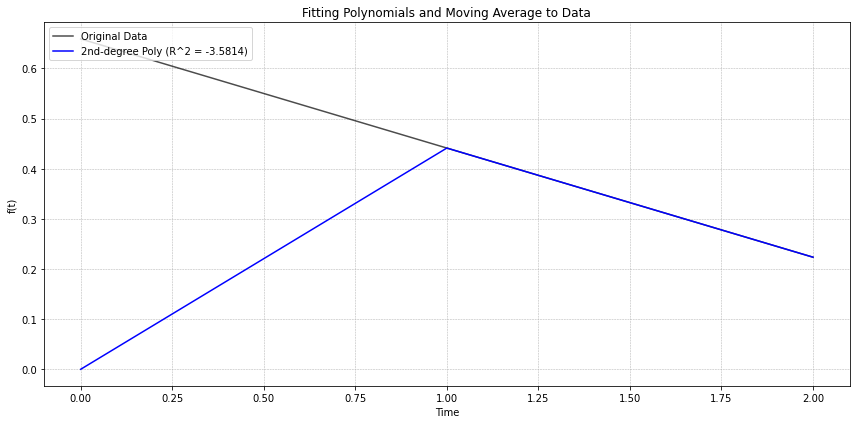

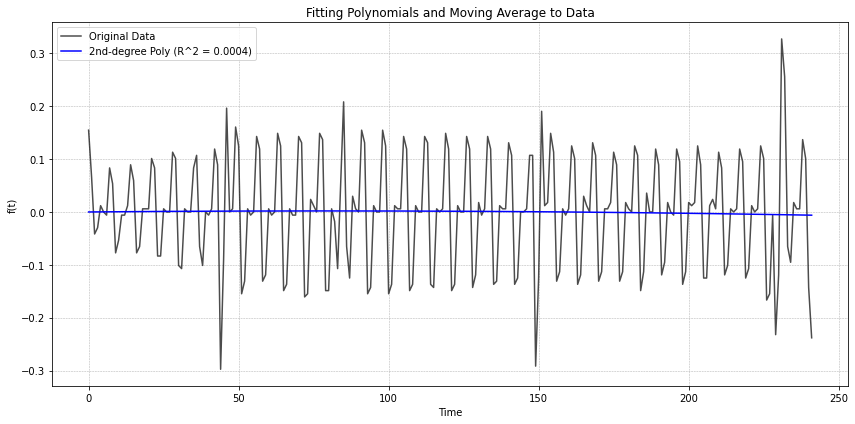

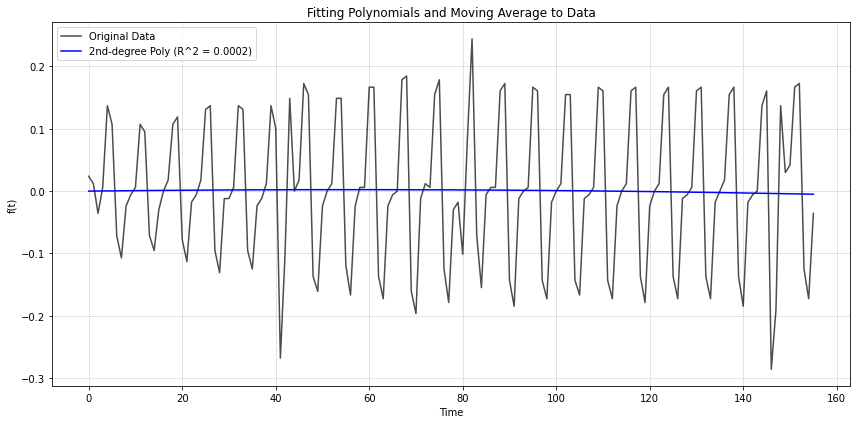

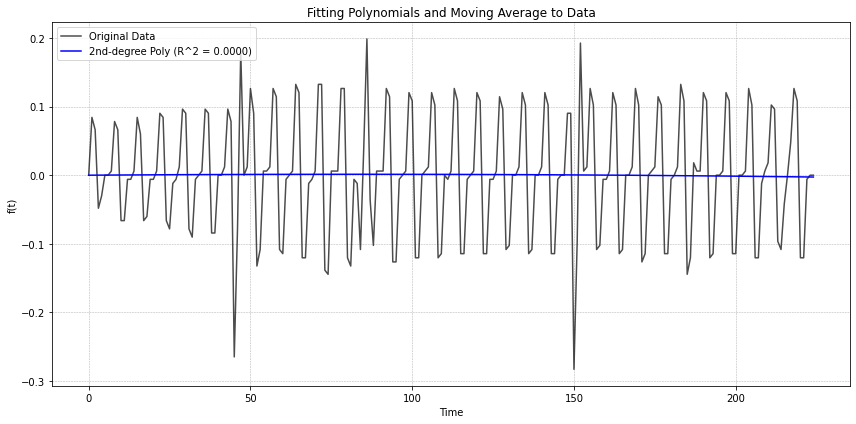

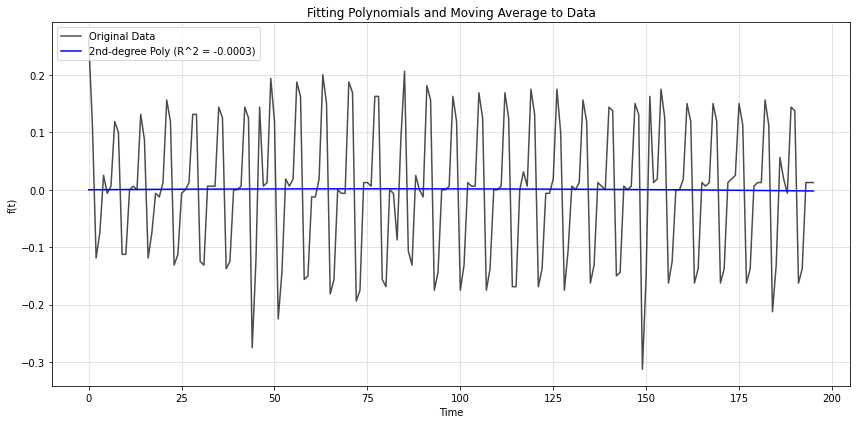

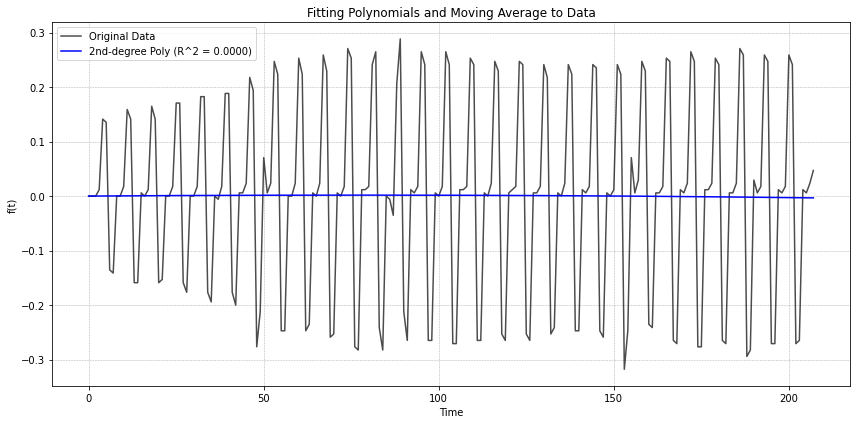

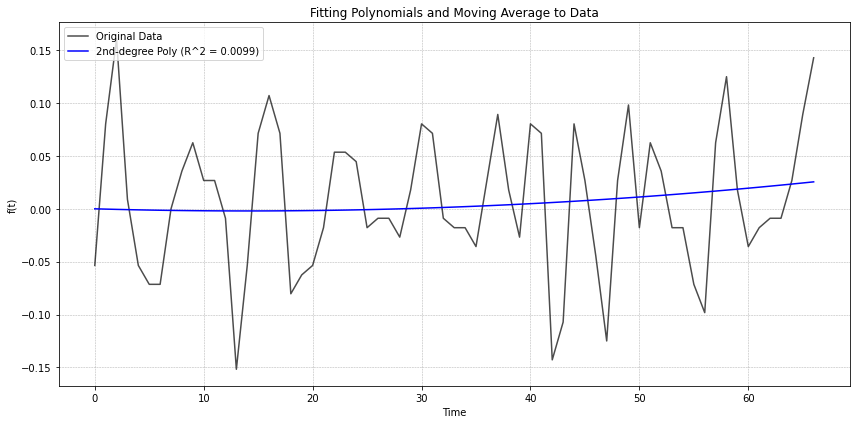

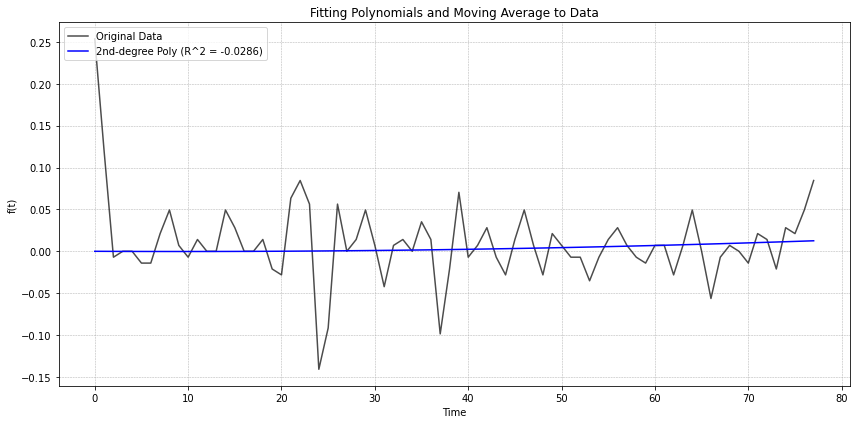

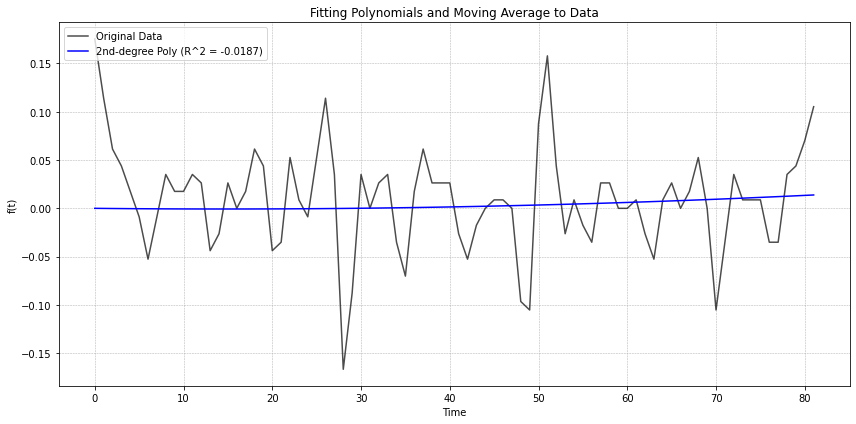

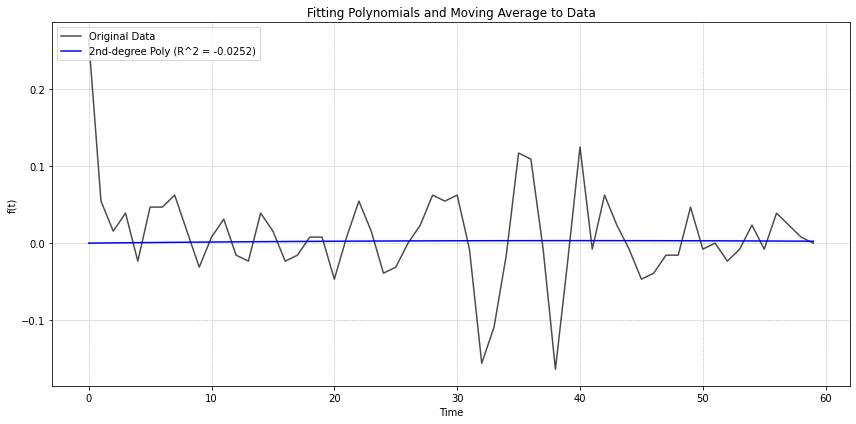

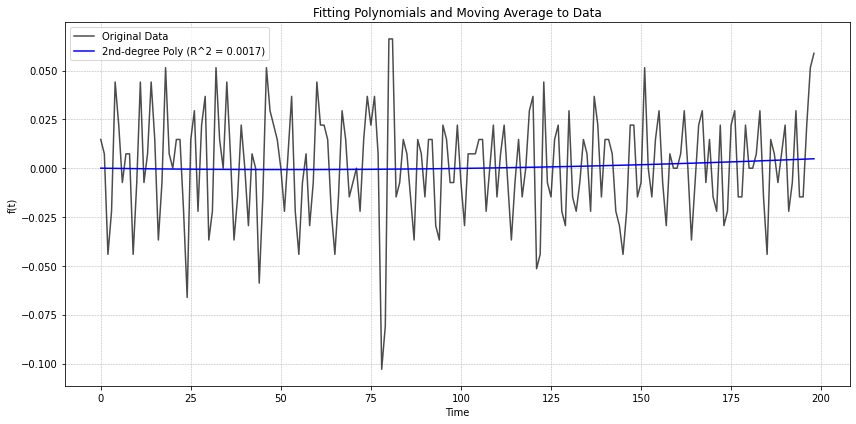

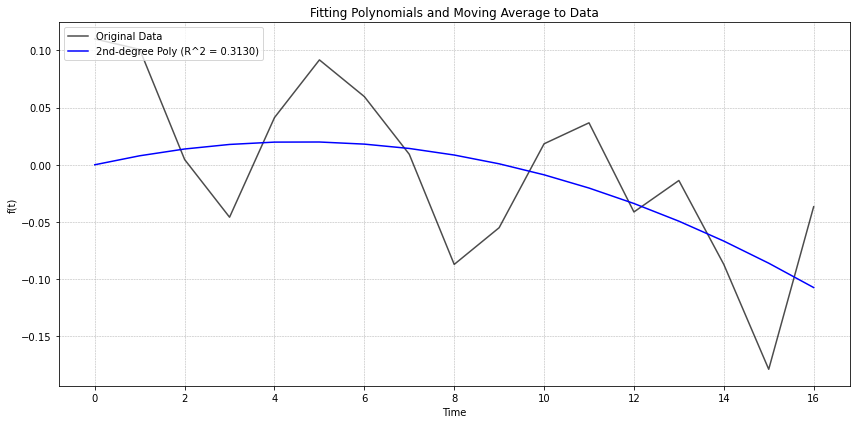

C:\Users\Eddie\AppData\Local\Temp\ipykernel_21088\237945364.py:68: RuntimeWarning: divide by zero encountered in true_divide
  h_t_suffix = f_t_suffix / (1 - F_t_suffix)
C:\Users\Eddie\AppData\Local\Temp\ipykernel_21088\237945364.py:93: RuntimeWarning: divide by zero encountered in true_divide
  h_t_poly_suffix = fitted_f_t_poly_suffix / (1 - F_t_suffix)


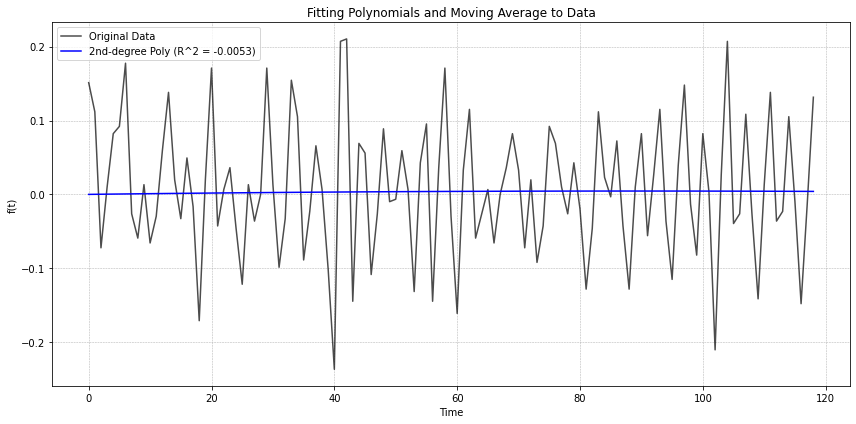

C:\Users\Eddie\AppData\Local\Temp\ipykernel_21088\237945364.py:152: RuntimeWarning: divide by zero encountered in true_divide
  h_t_ma_suffix = fitted_f_t_ma_suffix / (1 - F_t_suffix)


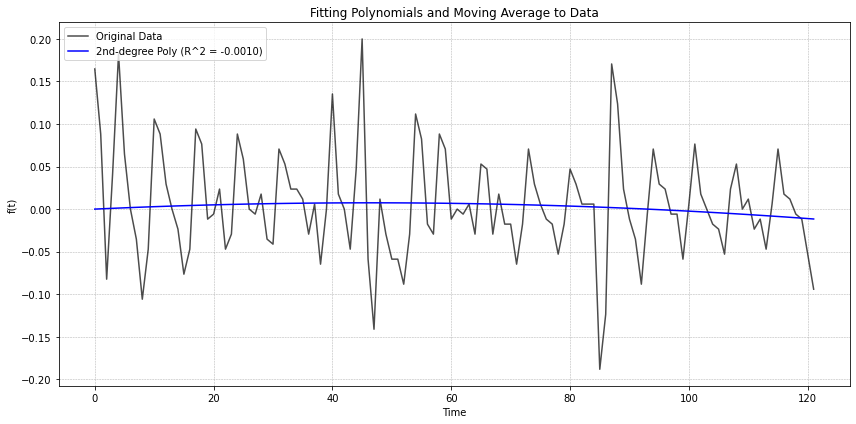

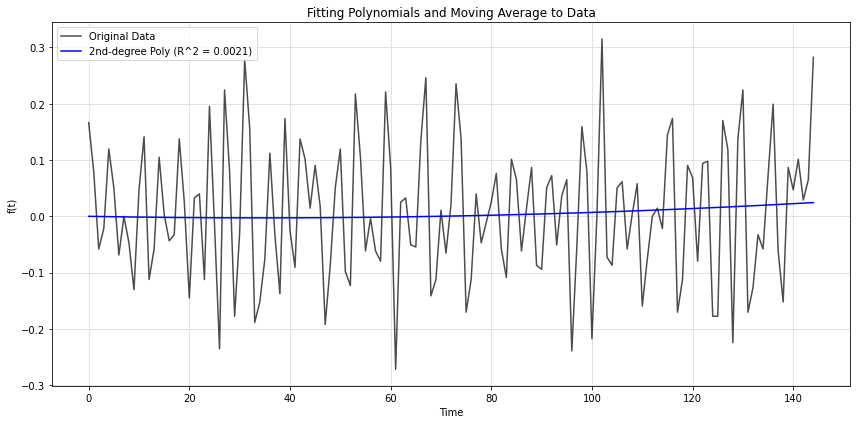

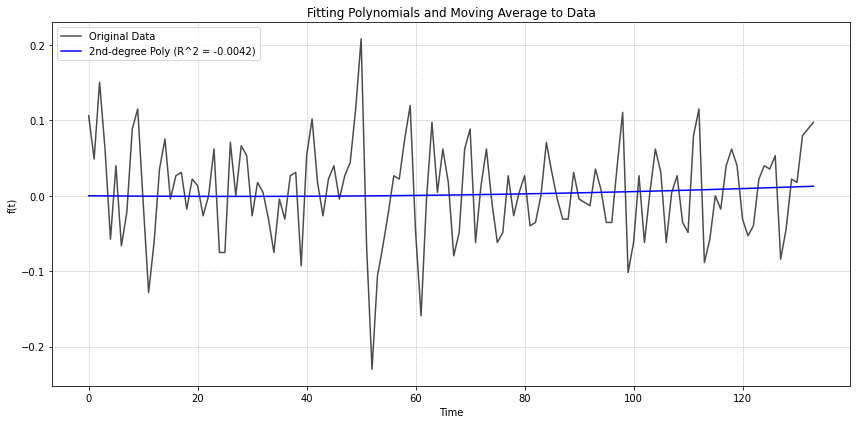

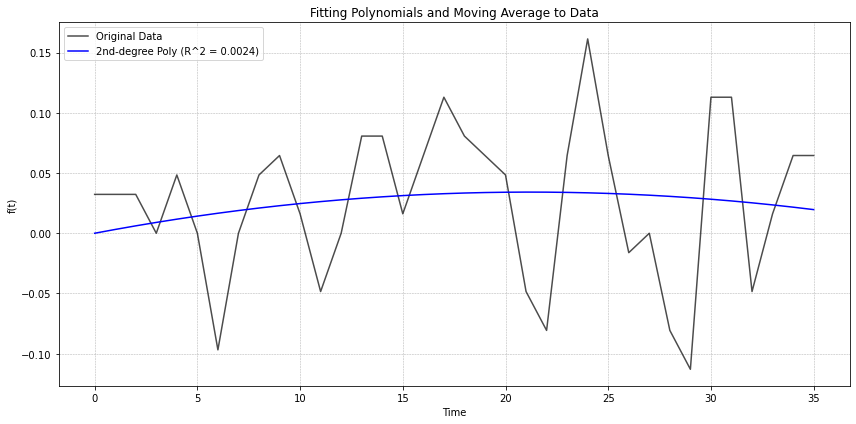

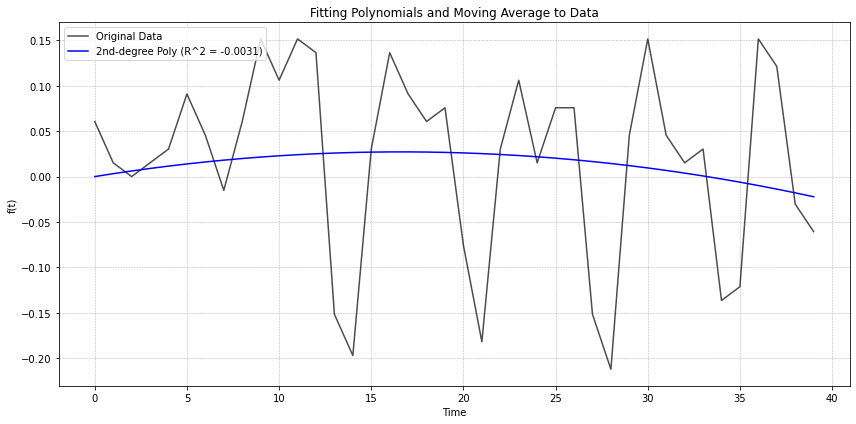

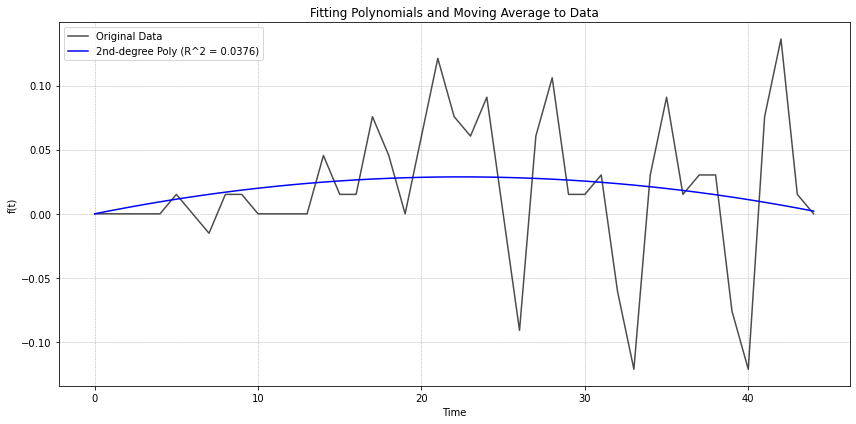

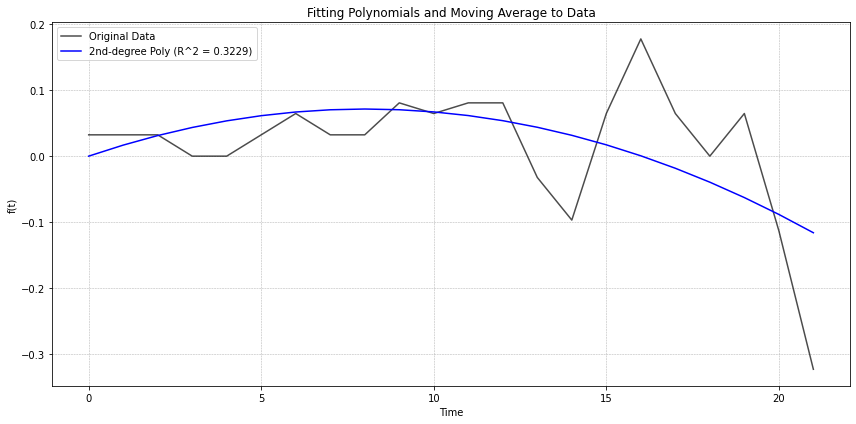

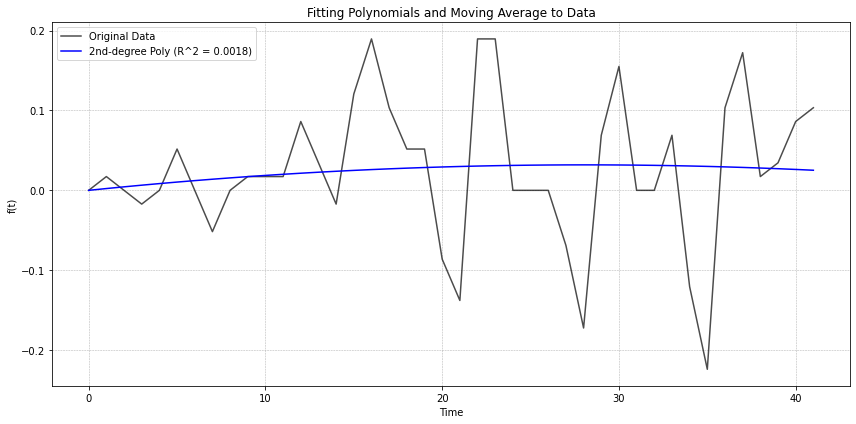

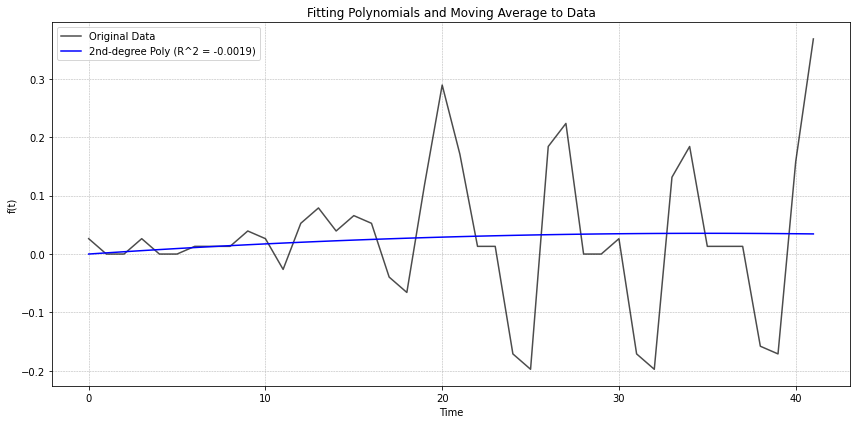

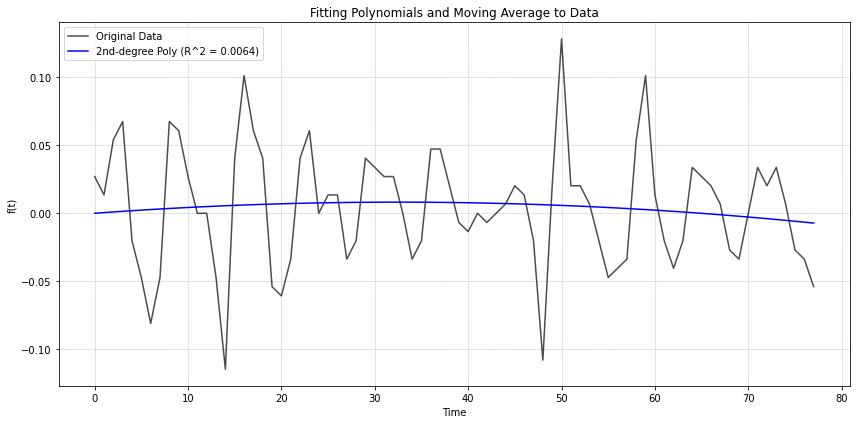

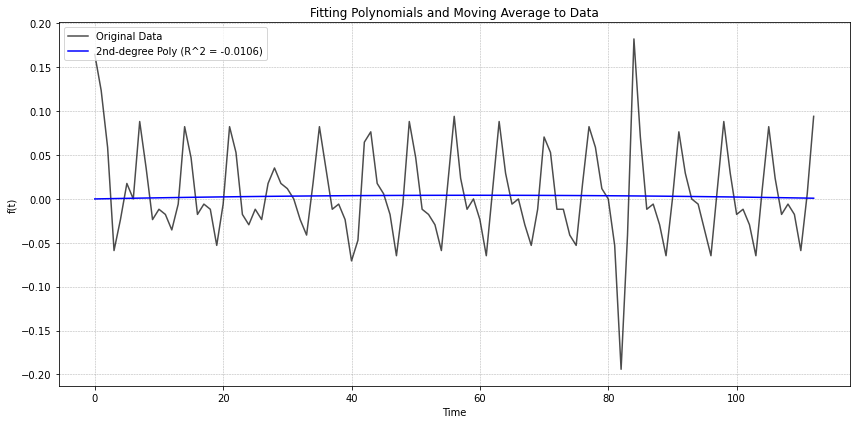

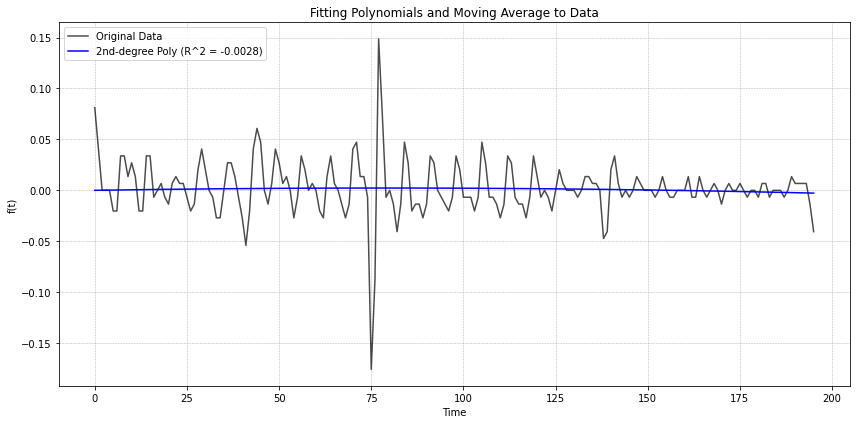

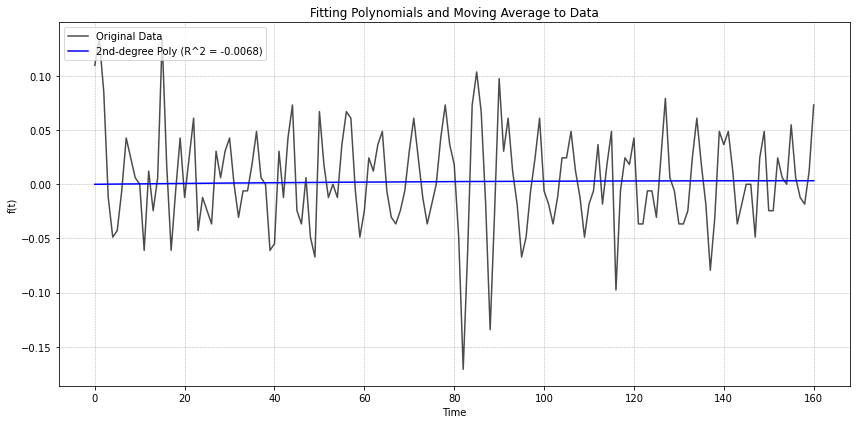

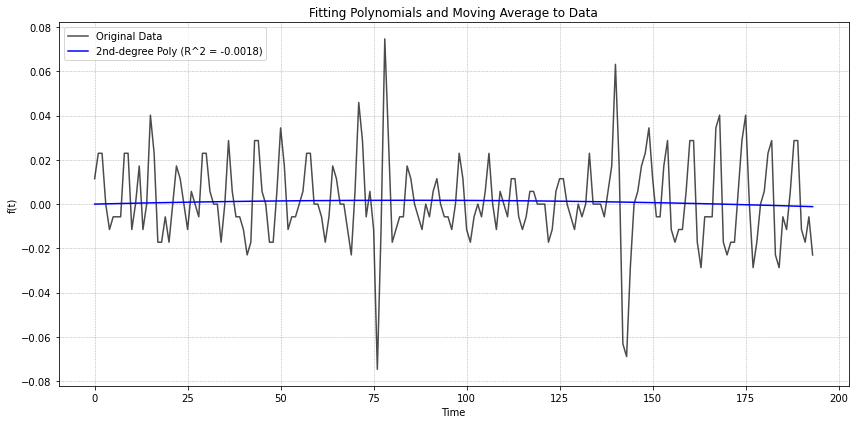

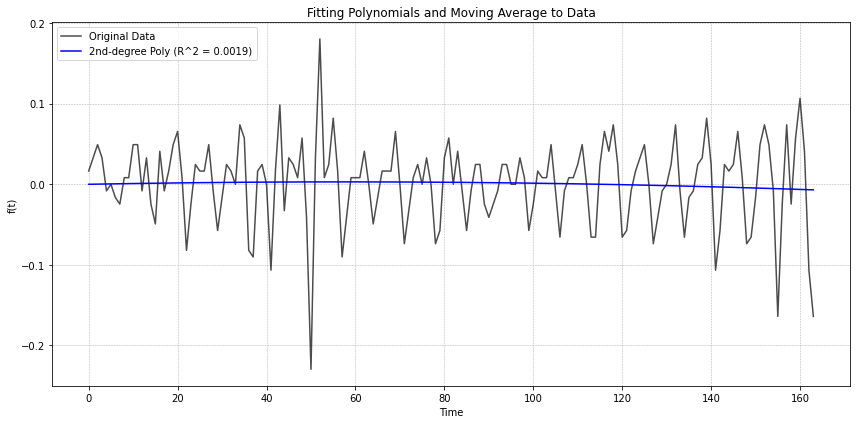

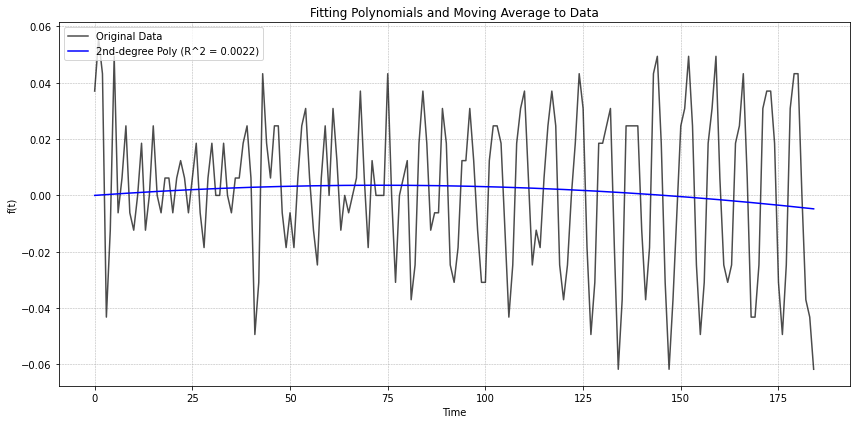

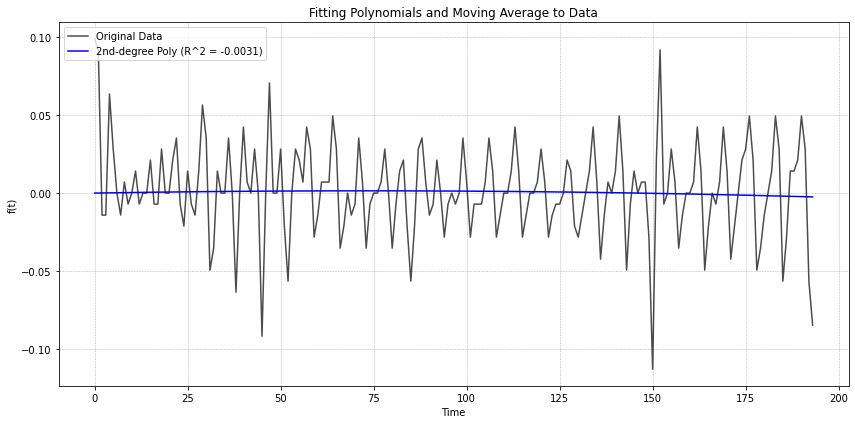

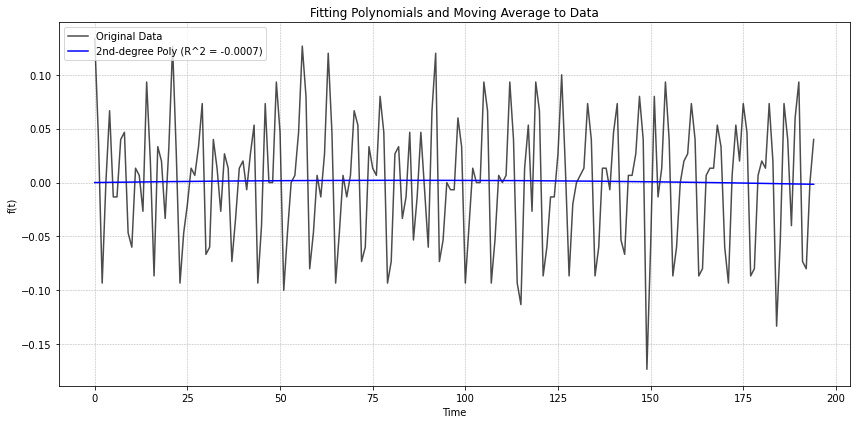

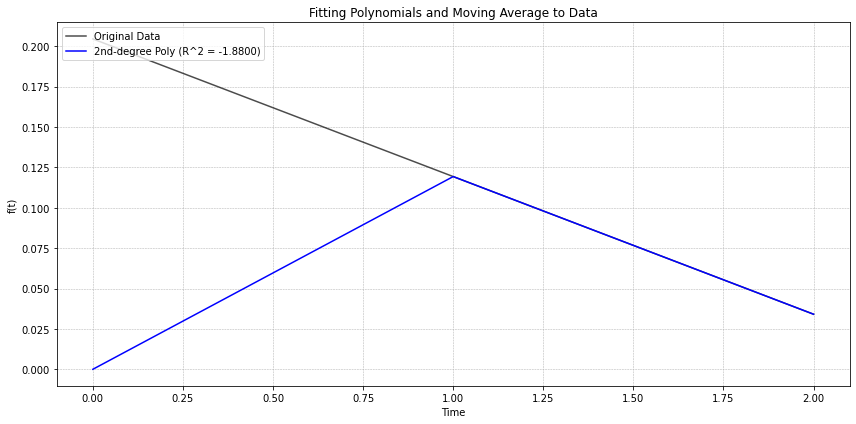

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score  # Import r2_score
from sklearn.metrics import mean_squared_error, r2_score


df = pd.DataFrame()

df_long_format = pd.DataFrame(columns=['city', 'mobility_type'])

mobility_types = dataset1['mobility_type'].unique()
print(mobility_types)

for mobility_type in mobility_types:
    dataset_filtered = dataset1[dataset1['mobility_type']
                                == mobility_type].reset_index(drop=True)
    if (mobility_type == 'residential_percent_change_from_baseline'):
        # print("residential____________")
        pass

        # print(dataset_filtered)
    for i in range(len(dataset_filtered)):
        city = dataset_filtered['city'][i]
        x_date = np.array(dataset_filtered['x_date'][i])
        queue_data = np.array(dataset_filtered['y_ridership_change_minmax'][i])
        t0 = 0
        t4 = int(dataset_filtered['t4']
                 [i]) - int(dataset_filtered['t0'][i])
        t2 = int(dataset_filtered['t2'][i]) - int(dataset_filtered['t0'][i])

        #print(mobility_type, state)

        queue_data = queue_data[t0:t4+1]

        #print(mobility_type, state)

        if (t4 < 0 or t2 > t4 or t2 < 0):
            print(mobility_type, city)
            print(t0, int(dataset_filtered['t2'][i]), int(
                dataset_filtered['t4'][i]))
            continue
        #time_index_of_min = np.argmin(queue_data)

        Qmax = dataset_filtered['Qmax'][i]
        mass = dataset_filtered['mass'][i]
        initial = queue_data[1]
        Delta = dataset_filtered['y_ridership_change'][i][t4]

        # Calculate Qmax, alpha, beta, etc. using modified_deviation

        h_t_prefix = np.full(t2, np.nan)
        t = np.array(range(len(queue_data[t2:t4+1])))

        # Original Data
        F_t_suffix = np.array(queue_data[t2:t4+1])
        F_t = np.concatenate((h_t_prefix, F_t_suffix))

        # S_t calculation
        S_t_suffix = 1 - F_t_suffix
        S_t = np.concatenate((h_t_prefix, S_t_suffix))

        # Derivative (Gradient)
        f_t_suffix = np.gradient(F_t_suffix)
        f_t = np.concatenate((h_t_prefix, f_t_suffix))

        # Calculate h_t
        h_t_suffix = f_t_suffix / (1 - F_t_suffix)
        h_t = np.concatenate((h_t_prefix, h_t_suffix))
        h_t[S_t == 0] = 0
        # 1. Polynomial Fit
        A = np.vstack([t**2, t]).T
        b = f_t_suffix

        # Solve the least squares problem
        coeffs, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

        # Construct the polynomial using the found coefficients
        a, b = coeffs
        fitted_f_t_poly_suffix = a * t**2 + b * t
        fitted_f_t_poly = np.concatenate((h_t_prefix, fitted_f_t_poly_suffix))

        A = np.vstack([t**3, t**2, t]).T
        b = f_t_suffix

        coeffs, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

        a, b, c = coeffs
        fitted_f_t_poly_3_suffix = a * t**3 + b * t**2 + c * t
        fitted_f_t_poly_3 = np.concatenate(
            (h_t_prefix, fitted_f_t_poly_3_suffix))
        # Calculate h_t using the polynomial fitted f_t
        h_t_poly_suffix = fitted_f_t_poly_suffix / (1 - F_t_suffix)
        h_t_poly = np.concatenate((h_t_prefix, h_t_poly_suffix))
        A = np.vstack([t**4, t**3, t**2, t]).T
        b = f_t_suffix

        # Solve the least squares problem
        coeffs, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

        # Construct the fourth-order polynomial using the found coefficients
        a, b, c, d = coeffs
        fitted_f_t_poly_4_suffix = a * t**4 + b * t**3 + c * t**2 + d * t
        fitted_f_t_poly_4 = np.concatenate(
            (h_t_prefix, fitted_f_t_poly_4_suffix))

        def compute_r2(y_obs, y_pred):
            ss_res = np.sum((y_obs - y_pred) ** 2)
            ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)
            return 1 - (ss_res / ss_tot)

        # 2. Moving Average
        f_t_series = pd.Series(f_t_suffix)
        fitted_f_t_ma_suffix = f_t_series.rolling(
            window=20, min_periods=1).mean().values
        fitted_f_t_ma = np.concatenate((h_t_prefix, fitted_f_t_ma_suffix))

        r2_ma = compute_r2(f_t_suffix, fitted_f_t_ma_suffix)

        r2_poly = compute_r2(f_t_suffix, fitted_f_t_poly_suffix)

        r2_poly_3 = compute_r2(f_t_suffix, fitted_f_t_poly_3_suffix)

        r2_poly_4 = compute_r2(f_t_suffix, fitted_f_t_poly_4_suffix)
        plt.figure(figsize=(12, 6))  # Makes the plot larger

        # Plot the original data and the fitted polynomials and moving average
        plt.plot(f_t_suffix, label='Original Data',
                 color='black', linewidth=1.5, alpha=0.7)
        plt.plot(fitted_f_t_poly_suffix,
                 label=f'2nd-degree Poly (R^2 = {r2_poly:.4f})', color='blue')
        '''plt.plot(fitted_f_t_poly_3_suffix,
                 label=f'3rd-degree Poly (R^2 = {r2_poly_3:.4f})', color='green')
        plt.plot(fitted_f_t_poly_4_suffix,
                 label=f'4th-degree Poly (R^2 = {r2_poly_4:.4f})', color='red')
        plt.plot(fitted_f_t_ma_suffix,
                 label=f'Moving Average (R^2 = {r2_ma:.4f})', color='purple', linestyle='--')'''

        # Add labels, legend, and title
        plt.xlabel('Time')
        plt.ylabel('f(t)')
        plt.title('Fitting Polynomials and Moving Average to Data')
        plt.legend(loc='upper left')
        # Adds a grid for better readability
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Show the plot
        plt.tight_layout()
        plt.show()

        # Calculate h_t using the moving average fitted f_t
        h_t_ma_suffix = fitted_f_t_ma_suffix / (1 - F_t_suffix)
        h_t_ma = np.concatenate((h_t_prefix, h_t_ma_suffix))

        # Padding to 250
        num_total = 500
        num_zeros_to_append = 500 - len(h_t)
        h_t = np.concatenate((h_t, np.full(num_zeros_to_append, np.nan)))
        f_t = np.concatenate((f_t, np.full(num_zeros_to_append, np.nan)))
        S_t = np.concatenate((S_t, np.full(num_zeros_to_append, np.nan)))
        F_t = np.concatenate((F_t, np.full(num_zeros_to_append, np.nan)))

        fitted_f_t_poly = np.concatenate(
            (fitted_f_t_poly, np.full(num_zeros_to_append, np.nan)))
        fitted_f_t_poly_3 = np.concatenate(
            (fitted_f_t_poly_3, np.full(num_zeros_to_append, np.nan)))
        fitted_f_t_poly_4 = np.concatenate(
            (fitted_f_t_poly_4, np.full(num_zeros_to_append, np.nan)))
        h_t_poly = np.concatenate(
            (h_t_poly, np.full(num_zeros_to_append, np.nan)))
        fitted_f_t_ma = np.concatenate(
            (fitted_f_t_ma, np.full(num_zeros_to_append, np.nan)))
        h_t_ma = np.concatenate((h_t_ma, np.full(num_zeros_to_append, np.nan)))

        '''plt.plot(F_t_suffix)
        plt.show()'''
        # Create DataFrame
        df = pd.DataFrame({
            'city': [city] * 500,
            'mobility_type': [mobility_type] * 500,
            "t": np.arange(500),
            'h(t)': h_t,
            'f(t)': f_t,
            'S(t)': S_t,
            'F(t)': F_t,
            'f(t)_poly_2': fitted_f_t_poly,
            'f(t)_poly_3': fitted_f_t_poly_3,
            'f(t)_poly_4': fitted_f_t_poly_4,
            'h(t)_poly': h_t_poly,
            'f(t)_ma': fitted_f_t_ma,
            'h(t)_ma': h_t_ma,
            'Qmax': [Qmax] * 500,
            'Mass': [mass] * 500,
            'Delta': [Delta] * 500
        })

        # Append the temporary DataFrame to the main long format DataFrame
        df_long_format = pd.concat(
            [df_long_format, df], ignore_index=True)


df_long_format.dropna(inplace=True)

df_long_format.to_csv(
    f'Results/Calculation Results/calculation_results_highest_pt_city.csv')


### Classify Trajectories

In [53]:
import pandas as pd

# Define the classification function


def classify_delta(delta):
    if delta > -1 and delta < 1:
        return "PN"
    elif delta > 1:
        return "PG"
    elif delta < -1:
        return "PL"


new_df = pd.read_csv('Datasets/LEA_aps.csv')

# 2. Merge the new dataframe with df_long_format based on state and mobility_type
merged_df = df_long_format.merge(new_df, left_on=['state', 'mobility_type'], right_on=[
                                 'State', 'Mobility Type'], how='left')

# Drop duplicated columns after merge
merged_df.drop(columns=['State', 'Mobility Type'], inplace=True)

merged_df = merged_df.drop_duplicates(
    subset=['state', 'mobility_type'], keep='last')

# Classifying Delta values for each row in df_long_format
merged_df["classification"] = merged_df["Delta"].apply(
    classify_delta)

# Grouping by mobility_type and computing the average percentage for each classification
classification_percentages_by_mobility = merged_df.groupby('mobility_type')[
    'classification'].value_counts(normalize=True).unstack().fillna(0) * 100

classification_percentages_by_mobility.reset_index(inplace=True)

# Computing the magnitude of Delta for each row in df_long_format
merged_df["Delta_magnitude"] = merged_df["Delta"].abs()

# Grouping by mobility_type and classification and computing the average magnitude of Delta
average_magnitudes = merged_df.groupby(['mobility_type', 'classification'])[
    'Delta_magnitude'].mean().unstack().reset_index()

# Renaming columns for clarity
average_magnitudes.columns.name = None
average_magnitudes.rename(columns={"PG": "Average_Magnitude_PG",
                          "PL": "Average_Magnitude_PL", "PN": "Average_Magnitude_PN"}, inplace=True)

# Merge classification_percentages_by_mobility and average_magnitudes on mobility_type
combined_df = pd.merge(classification_percentages_by_mobility,
                       average_magnitudes, on='mobility_type')

# Compute the average 'p' for each classification grouped by mobility_type
average_p_by_mobility_and_classification = merged_df.groupby(
    ['mobility_type', 'classification'])['p'].mean().unstack().reset_index()

# Renaming columns for clarity
average_p_by_mobility_and_classification.columns.name = None
average_p_by_mobility_and_classification.rename(
    columns={"PG": "Average_p_PG", "PL": "Average_p_PL", "PN": "Average_p_PN"}, inplace=True)

# Merge the average_p values to the combined_df
combined_df = pd.merge(
    combined_df, average_p_by_mobility_and_classification, on='mobility_type')

# Exporting the combined DataFrame to CSV
combined_df.to_csv('combined_results_by_mobility_type.csv', index=False)

combined_df


,mobility_type,PG,PL,PN,Average_Magnitude_PG,Average_Magnitude_PL,Average_Magnitude_PN,Average_p_PG,Average_p_PL,Average_p_PN
0,grocery_and_pharmacy_percent_change_from_baseline,32.692308,65.384615,1.923077,9.852134,10.512094,0.214286,71.102643,45.046566,46.094431
1,parks_percent_change_from_baseline,77.142857,20.000000,2.857143,52.943937,17.296021,0.000000,61.865714,26.728361,136.611143
2,residential_percent_change_from_baseline,100.000000,0.000000,0.000000,16.533705,NaN,NaN,27.813469,NaN,NaN
3,retail_and_recreation_percent_change_from_base...,3.846154,94.230769,1.923077,4.421429,15.519734,0.404762,63.699464,62.611633,48.279077
4,transit_stations_percent_change_from_baseline,11.538462,88.461538,0.000000,15.357143,21.213900,NaN,89.879610,65.834314,NaN
5,workplaces_percent_change_from_baseline,0.000000,100.000000,0.000000,NaN,29.823496,NaN,NaN,49.461277,NaN


In [25]:
import pandas as pd

# Define the classification function


def classify_delta(delta):
    if delta > -1 and delta < 1:
        return "PN"
    elif delta > 1:
        return "PG"
    elif delta < -1:
        return "PL"


new_df = pd.read_csv('Datasets/LEA_aps.csv')

# 2. Merge the new dataframe with df_long_format based on state and mobility_type
merged_df = df_long_format.merge(new_df, left_on=['city', 'mobility_type'], right_on=[
                                 'city', 'Mobility Type'], how='left')

# Drop duplicated columns after merge
merged_df.drop(columns=['city', 'Mobility Type'], inplace=True)

merged_df = merged_df.drop_duplicates(
    subset=['city', 'mobility_type'], keep='last')

# Classifying Delta values for each row in df_long_format
merged_df["classification"] = merged_df["Delta"].apply(
    classify_delta)

# Grouping by mobility_type and computing the average percentage for each classification
classification_percentages_by_mobility = merged_df.groupby('mobility_type')[
    'classification'].value_counts(normalize=True).unstack().fillna(0) * 100

classification_percentages_by_mobility.reset_index(inplace=True)

# Computing the magnitude of Delta for each row in df_long_format
merged_df["Delta_magnitude"] = merged_df["Delta"].abs()

# Grouping by mobility_type and classification and computing the average magnitude of Delta
average_magnitudes = merged_df.groupby(['mobility_type', 'classification'])[
    'Delta_magnitude'].mean().unstack().reset_index()

# Renaming columns for clarity
average_magnitudes.columns.name = None
average_magnitudes.rename(columns={"PG": "Average_Magnitude_PG",
                          "PL": "Average_Magnitude_PL", "PN": "Average_Magnitude_PN"}, inplace=True)

# Merge classification_percentages_by_mobility and average_magnitudes on mobility_type
combined_df = pd.merge(classification_percentages_by_mobility,
                       average_magnitudes, on='mobility_type')

# Compute the average 'p' for each classification grouped by mobility_type
average_p_by_mobility_and_classification = merged_df.groupby(
    ['mobility_type', 'classification'])['p'].mean().unstack().reset_index()

# Renaming columns for clarity
average_p_by_mobility_and_classification.columns.name = None
average_p_by_mobility_and_classification.rename(
    columns={"PG": "Average_p_PG", "PL": "Average_p_PL", "PN": "Average_p_PN"}, inplace=True)

# Merge the average_p values to the combined_df
combined_df = pd.merge(
    combined_df, average_p_by_mobility_and_classification, on='mobility_type')

# Exporting the combined DataFrame to CSV
combined_df.to_csv('combined_results_by_mobility_type_city.csv', index=False)

combined_df


KeyError: 'city'